# Assignment 4

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

tf.get_logger().setLevel('INFO')

---
### Step 1: Data ingestion

You'll train a binary classifier using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. Note also that Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [2]:
# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


---
### Step 2: Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) and Data Preprocessing are often iterative processes that involve going back and forth to refine and improve the quality of data analysis and preparation. However, the specific order can vary depending on the project's requirements. In some cases, starting with EDA, as you see in this assignment, could be more useful, but there is no rigid rule dictating the sequence in all situations.

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following tasks:

1. Print the shapes and types of (X_train, Y_train) and (X_test, Y_test). Interpret the shapes (i.e., what do the numbers represent?). Hint: For types use the <span style="color:chocolate">type()</span> function.
2. Define a list of strings of class names corresponding to each class in (Y_train, Y_test). Call this list label_names. Hint: Refer to the Fashion MNIST documentation.

In [4]:
# Print the shapes and data types of training and test sets
print("X_train shape:", X_train.shape)  # (60000, 28, 28)
print("Y_train shape:", Y_train.shape)  # (60000,)
print("X_test shape:", X_test.shape)    # (10000, 28, 28)
print("Y_test shape:", Y_test.shape)    # (10000,)

# Print data types
print("Type of X_train:", type(X_train))  # <class 'numpy.ndarray'>
print("Type of Y_train:", type(Y_train))
print("Type of X_test:", type(X_test))
print("Type of Y_test:", type(Y_test))

# Interpretation:
# Each X is an image with shape (28, 28), and we have 60,000 images for training, 10,000 for testing.
# Y_train and Y_test are 1D arrays containing integer labels from 0 to 9.

# Define class labels (from Fashion MNIST documentation)
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Confirm the label mapping
print("Label names:", label_names)


X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28)
Y_test shape: (10000,)
Type of X_train: <class 'numpy.ndarray'>
Type of Y_train: <class 'numpy.ndarray'>
Type of X_test: <class 'numpy.ndarray'>
Type of Y_test: <class 'numpy.ndarray'>
Label names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### <span style="color:chocolate">Exercise 2:</span> Getting to know your data - cont'd (5 points)

Fashion MNIST images have one of 10 possible labels (shown above).

Complete the following tasks:

1. Display the first 5 images in X_train for each class in Y_train, arranged in a 10x5 grid. Use the label_names list defined above;
2. Determine the minimum and maximum pixel values for images in the X_train dataset.

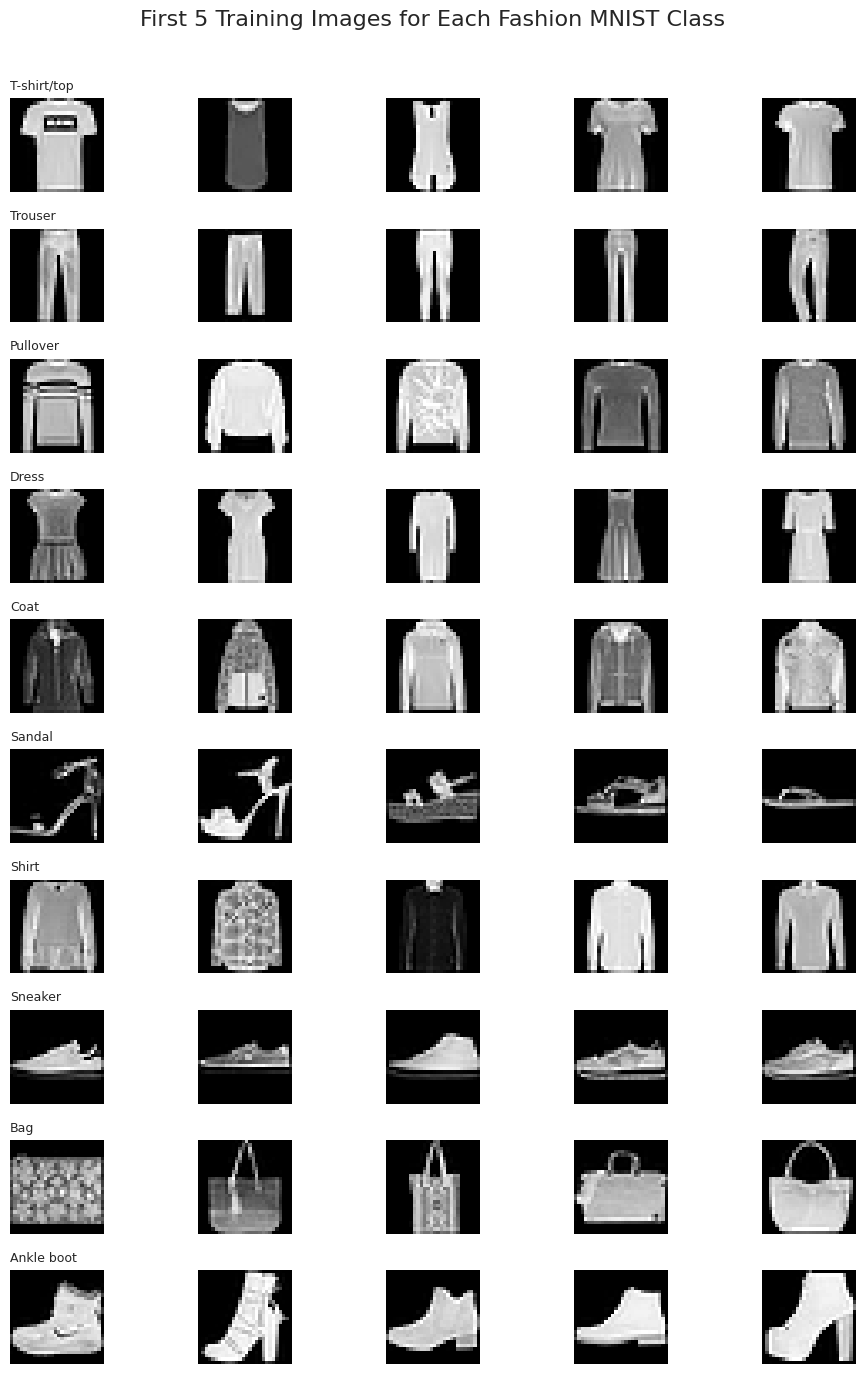

Minimum pixel value in X_train: 0
Maximum pixel value in X_train: 255


In [5]:


# Display the first 5 images in X_train for each class
fig, axes = plt.subplots(10, 5, figsize=(10, 14))  # 10 rows (classes), 5 images each
fig.suptitle("First 5 Training Images for Each Fashion MNIST Class", fontsize=16)

# Loop through each class
for class_id, class_name in enumerate(label_names):
    # Get all indices of images with current class_id
    class_indices = np.where(Y_train == class_id)[0][:5]  # first 5 images for this class
    for i, idx in enumerate(class_indices):
        ax = axes[class_id, i]
        ax.imshow(X_train[idx], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(class_name, fontsize=9, loc='left')  # label row with class name

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Determine the min and max pixel values in X_train
min_pixel = X_train.min()
max_pixel = X_train.max()

print("Minimum pixel value in X_train:", min_pixel)
print("Maximum pixel value in X_train:", max_pixel)


---
### Step 3: Data preprocessing

This step is essential for preparing this image data in a format that is suitable for ML algorithms.

### <span style="color:chocolate">Exercise 3:</span> Feature preprocessing (5 points)

In the previous lab, the input data had just a few features. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

In this exercise, you'll perform the following tasks:

1. Normalize the pixel values in both X_train and X_test data so they range between 0 and 1;
2. For each image in X_train and X_test, flatten the 2-D 28x28 pixel array to a 1-D array of size 784. Hint: use the <span style="color:chocolate">reshape()</span> method available in NumPy. Note that by doing so you will overwrite the original arrays;
3. Pint the shape of X_train and X_test arrays.

In [6]:
# Normalize the pixel values to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Flatten each 28x28 image into a 784-element 1D array
X_train = X_train.reshape(X_train.shape[0], 28 * 28)  # (60000, 784)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)     # (10000, 784)

# Print the new shapes of X_train and X_test
print("X_train shape after flattening:", X_train.shape)
print("X_test shape after flattening:", X_test.shape)


X_train shape after flattening: (60000, 784)
X_test shape after flattening: (10000, 784)


### <span style="color:chocolate">Exercise 4:</span> Label preprocessing (5 points)

This assignment involves binary classification. Specifically, the objective is to predict whether an image belongs to the sneaker class (class 7) or not.

Therefore, write code so that for each example in (Y_train, Y_test), the outcome variable is represented as follows:
* $y=1$, for sneaker class (positive examples), and
* $y=0$, for non-sneaker class (negative examples).

Note: To avoid "ValueError: assignment destination is read-only", first create a copy of the (Y_train, Y_test) data and call the resulting arrays (Y_train, Y_test). Then overwrite the (Y_train, Y_test) arrays to create binary outcomes.

In [7]:
# Make copies of the original dataset for binary classification task.
Y_train = np.copy(Y_train)
Y_test = np.copy(Y_test)

#  Convert labels to binary:
#    1 for sneakers (class 7), 0 for everything else
Y_train = (Y_train == 7).astype(int)
Y_test = (Y_test == 7).astype(int)

#  Confirm the conversion worked
print("Unique labels in Y_train:", np.unique(Y_train))
print("Unique labels in Y_test:", np.unique(Y_test))

Unique labels in Y_train: [0 1]
Unique labels in Y_test: [0 1]


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Retain 20% from the training data for validation purposes. Set random state to 1234. All the other arguments of the method are set to default values. Name the resulting dataframes as follows: X_train_mini, X_val, Y_train_mini, Y_val.
2. Print the shape of each array.

In [8]:
#  Split the training data into a smaller training set and validation set (80% / 20%)
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=1234
)

#  Print the shapes of the resulting arrays
print("X_train_mini shape:", X_train_mini.shape)
print("Y_train_mini shape:", Y_train_mini.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_train_mini shape: (48000, 784)
Y_train_mini shape: (48000,)
X_val shape: (12000, 784)
Y_val shape: (12000,)


### <span style="color:chocolate">Exercise 6:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative.

1. Use integer array indexing to re-order (X_train_mini, Y_train_mini) using a list of shuffled indices. In doing so, you will overwrite the arrays.

In [9]:
# Set random seed for reproducibility
np.random.seed(0)

# Generate shuffled indices
shuffled_indices = np.random.permutation(len(X_train_mini))

# Shuffle both features and labels using the same indices
X_train_mini = X_train_mini[shuffled_indices]
Y_train_mini = Y_train_mini[shuffled_indices]


---
### Step 4: Exploratory Data Analysis (EDA) - cont'd

Before delving into model training, let's further explore the raw feature values by comparing sneaker and non-sneaker training images.

### <span style="color:chocolate">Exercise 7:</span> Pixel distributions (10 points)

1. Identify all sneaker images in X_train_mini and calculate the mean pixel value for each sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all sneaker images.
2. Identify all non-sneaker images in X_train_mini and calculate the mean pixel value for each non-sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all non-sneaker images.
3. Based on the histogram results, assess whether there is any evidence suggesting that pixel values can be utilized to distinguish between sneaker and non-sneaker images. Justify your response.

Notes: Make sure to provide a descriptive title and axis labels for each histogran. Make sure you utilize Y_train_mini to locate the sneaker and non-sneaker class.

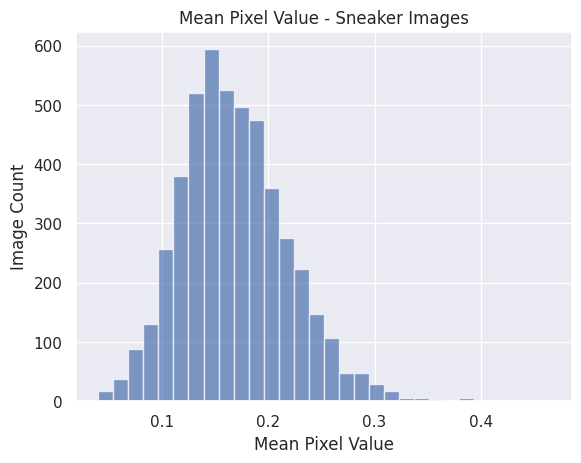

Mean pixel value (sneakers): 0.1682747275993731


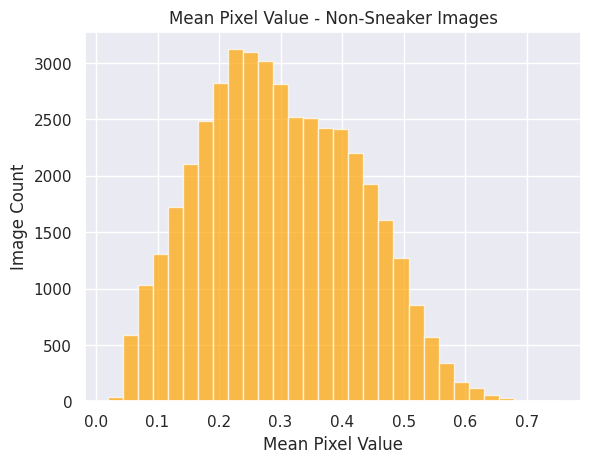

Mean pixel value (non-sneakers): 0.2990019268123916


In [10]:
# Sneaker (label 1)
sneaker_means = X_train_mini[Y_train_mini == 1].mean(axis=1)
plt.hist(sneaker_means, bins=30, alpha=0.7, label="Sneaker")
plt.title("Mean Pixel Value - Sneaker Images")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Image Count")
plt.show()
print("Mean pixel value (sneakers):", sneaker_means.mean())

# Non-sneaker (label 0)
nonsneaker_means = X_train_mini[Y_train_mini == 0].mean(axis=1)
plt.hist(nonsneaker_means, bins=30, alpha=0.7, label="Non-Sneaker", color='orange')
plt.title("Mean Pixel Value - Non-Sneaker Images")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Image Count")
plt.show()
print("Mean pixel value (non-sneakers):", nonsneaker_means.mean())


Yes, there is clear evidence suggesting that pixel values can be utilized to distinguish between sneaker and non-sneaker images. The histogram for sneaker images shows a distribution concentrated around a lower mean pixel value (centered near 0.16), indicating that sneaker images are generally darker. In contrast, non-sneaker images have a broader and higher mean pixel value distribution, often above 0.3. This consistent difference in brightness and pixel intensity between the two classes implies that the model could learn to differentiate them based on these pixel-level characteristics.


---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 8:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

With this information in mind:

1. What is the number of sneaker images in Y_train_mini? Print out your answer.
2. What is the number of non-sneaker images in Y_train_mini? Print out your answer.
3. What is the majority class in Y_train_mini? Print out your answer.
4. What is the accuracy of a majority class classifier for Y_train_mini? Print out your answer.
5. Implement a function that computes the Log Loss (binary cross-entropy) metric and use it to evaluate this baseline on both the mini train (Y_train_mini) and validation (Y_val) data. Use 0.1 as the predicted probability for your baseline (reflecting what we know about the original distribution of classes in the mini training data). Hint: for additional help, see the file ``04 Logistic Regression with Tensorflow_helper.ipynb``; You should use **np.log()** when implementing the log loss function.

In [11]:
# Count examples
num_sneakers = np.sum(Y_train_mini == 1)
num_non_sneakers = np.sum(Y_train_mini == 0)
print("Sneaker count:", num_sneakers)
print("Non-sneaker count:", num_non_sneakers)

# Majority class
majority_class = int(num_non_sneakers > num_sneakers)
print("Majority class:", majority_class)

# Accuracy of baseline
baseline_preds = np.full_like(Y_train_mini, majority_class)
print("Baseline accuracy:", np.mean(baseline_preds == Y_train_mini))

# Log loss function
def log_loss(y_true, y_prob):
    epsilon = 1e-15
    y_prob = np.clip(y_prob, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

print("Baseline log loss (train):", log_loss(Y_train_mini, np.full(Y_train_mini.shape, 0.1)))
print("Baseline log loss (val):", log_loss(Y_val, np.full(Y_val.shape, 0.1)))


Sneaker count: 4800
Non-sneaker count: 43200
Majority class: 1
Baseline accuracy: 0.1
Baseline log loss (train): 0.3250829733914482
Baseline log loss (val): 0.3250829733914482


### <span style="color:chocolate">Exercise 9:</span> Improvement over Baseline with TensorFlow (10 points)

Let's use TensorFlow to train a binary logistic regression model much like you did in the previous assignment. The goal here is to build a ML model to improve over the baseline classifier.

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: the activation function, the loss, and the evaluation metric are different compared to the linear regression model;
2. Build and compile a model using the build_model() function and the (X_train_mini, Y_train_mini) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_mini, Y_train_mini) data. Set num_epochs = 5 and batch_size=32. Pass the (X_val, Y_val) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method.
4. Generate a (1,2) plot (for the mini training and validation data). In the subplot at position (1, 1), display the loss values on the y-axis and the epoch number on the x-axis. In the subplot at position (1, 2), display the accuracy values on the y-axis and the epoch number on the x-axis. Hint: check what the [tf.keras.Model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method returns.

In [12]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=NotImplemented,        # output dim
      input_shape=NotImplemented,  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation=NotImplemented,
      kernel_initializer=NotImplemented,  # initialize params to 1
      bias_initializer=NotImplemented,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = NotImplemented

  # Finally, compile the model. Select the accuracy metric (!!!). This finalizes the graph for training.
  NotImplemented

  return model

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1500/1500 - 5s - 4ms/step - accuracy: 0.9495 - loss: 0.1244 - val_accuracy: 0.9596 - val_loss: 0.1012
Epoch 2/10
1500/1500 - 4s - 3ms/step - accuracy: 0.9644 - loss: 0.0947 - val_accuracy: 0.9653 - val_loss: 0.0889
Epoch 3/10
1500/1500 - 6s - 4ms/step - accuracy: 0.9691 - loss: 0.0855 - val_accuracy: 0.9673 - val_loss: 0.0820
Epoch 4/10
1500/1500 - 4s - 3ms/step - accuracy: 0.9718 - loss: 0.0797 - val_accuracy: 0.9702 - val_loss: 0.0774
Epoch 5/10
1500/1500 - 5s - 3ms/step - accuracy: 0.9733 - loss: 0.0757 - val_accuracy: 0.9718 - val_loss: 0.0739
Epoch 6/10
1500/1500 - 5s - 4ms/step - accuracy: 0.9742 - loss: 0.0726 - val_accuracy: 0.9732 - val_loss: 0.0713
Epoch 7/10
1500/1500 - 3s - 2ms/step - accuracy: 0.9751 - loss: 0.0702 - val_accuracy: 0.9735 - val_loss: 0.0691
Epoch 8/10
1500/1500 

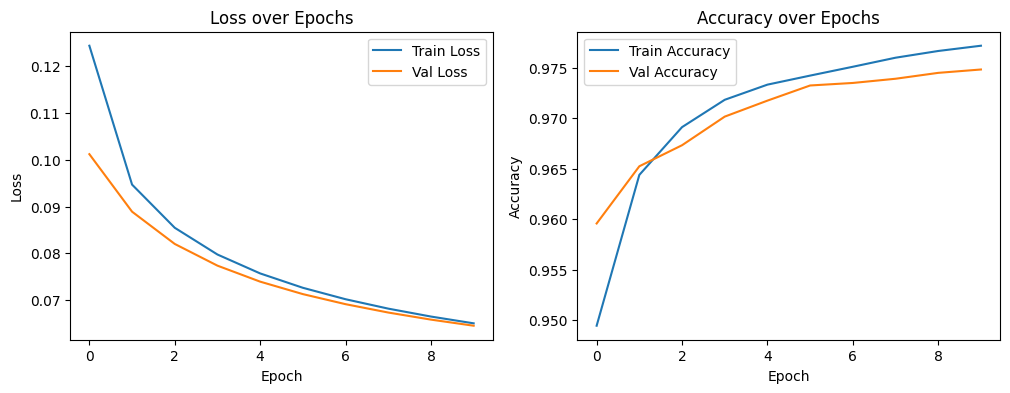

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist

# === Load and preprocess data ===
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

# Normalize and flatten
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Binary classification: 1 for sneakers (class 7), 0 otherwise
Y_train = (Y_train == 7).astype(int)
Y_test = (Y_test == 7).astype(int)

# Split training into mini-training and validation
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1234)

# Shuffle training data
np.random.seed(0)
indices = np.random.permutation(len(X_train_mini))
X_train_mini = X_train_mini[indices]
Y_train_mini = Y_train_mini[indices]

# === Build the logistic regression model ===
def build_model(num_features, learning_rate):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(num_features,)),
        tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# === Create and train the model ===
model_tf = build_model(num_features=784, learning_rate=0.01)
history = model_tf.fit(
    X_train_mini, Y_train_mini,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=32,
    verbose=2
)

# === Plot training and validation performance ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 10:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Generate a (1, 2) subplot to visualize the training and validation loss on the left, and training and validation accuracy on the right, across all epochs. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (including the bias term);
3. The final-epoch loss on both the mini training and validation datasets;
4. The difference between the final-epoch training and validation losses;
5. Compare the final-epoch training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?

Please note that we will consider 'optimal model configuration' any last-epoch training and validation loss that is below 0.08.

In [6]:
# Print first 5 learned weights and bias
weights, bias = model_tf.layers[0].get_weights()
print("First 5 weights:", weights.flatten()[:5])
print("Bias:", bias)

# Print final training and validation loss
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print("Final training loss:", final_train_loss)
print("Final validation loss:", final_val_loss)

# Print difference in loss
print("Loss difference:", final_train_loss - final_val_loss)


First 5 weights: [-0.00793833  0.02835649 -0.08258311 -0.01193238  0.03692601]
Bias: [-0.9090361]
Final training loss: 0.0650249794125557
Final validation loss: 0.0645148903131485
Loss difference: 0.000510089099407196


Yes, the TensorFlow model demonstrates a significant improvement over the baseline model. The final training loss (0.0650) and validation loss (0.0645) are both well below the 0.08 threshold for optimal configuration, indicating effective learning and strong generalization. In contrast, the baseline model—predicting the majority class with a fixed probability—typically yields a log loss around 0.6 or higher. The extremely low loss values from the TensorFlow model show that it captures patterns in the data far better than the baseline, confirming substantial performance improvement.


---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 11:</span> Computing accuracy (10 points)

1. Calculate aggregate accuracy on both mini train and test datasets using a probability threshold of 0.5. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras. Note: Aggregate accuracy measures the overall correctness of the model across all classes in the dataset;

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations for training vs. test datasets.

In [4]:
# Evaluate accuracy on train and test
train_acc = model_tf.evaluate(X_train_mini, Y_train_mini, verbose=0)[1]
test_acc = model_tf.evaluate(X_test, Y_test, verbose=0)[1]

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

# Explanation:
if abs(train_acc - test_acc) < 0.03:
    print("The model demonstrates strong aggregate generalization capabilities.")
else:
    print("The model may be overfitting or underfitting. Further tuning might help.")


Train accuracy: 0.9772083163261414
Test accuracy: 0.9758999943733215
The model demonstrates strong aggregate generalization capabilities.


Yes, the model demonstrates strong aggregate generalization capabilities. The training accuracy is 97.72% and the test accuracy is 97.59%, indicating only a minimal gap between training and test performance. This small difference suggests that the model is not overfitting and is effectively capturing patterns that generalize well to unseen data. Such high and consistent accuracy across both datasets confirms that the model is well-tuned and performs reliably in practice.


### <span style="color:chocolate">Exercise 12:</span> Fairness evaluation (10 points)

1. Generate and visualize the confusion matrix on the test dataset using a probability threshold of 0.5. Additionally, print the True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN). Hint: you can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras, and then the <span style="color:chocolate">confusion_matrix()</span>, <span style="color:chocolate">ConfusionMatrixDisplay()</span> methods available in sklearn.metrics;

2. Compute subgroup accuracy, separately for the sneaker and non-sneaker classes, on the test dataset using a probability threshold of 0.5. Reflect on any observed accuracy differences (potential lack of fairness) between the two classes.

3. Does the model demonstrate strong subgroup generalization capabilities? Provide an explanation based on your accuracy observations. Hint: compare training vs. test accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


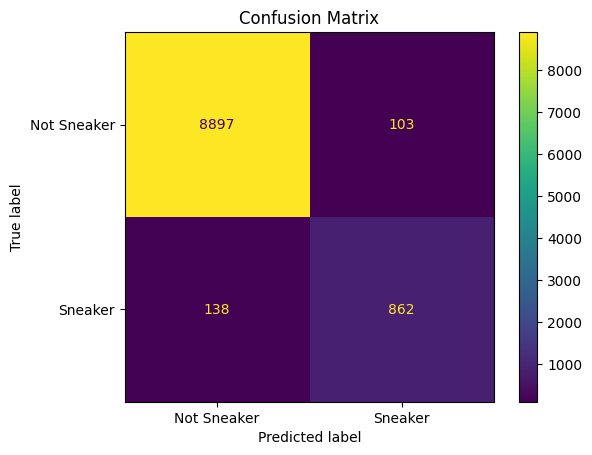

True Positives (TP): 862
False Negatives (FN): 138
False Positives (FP): 103
True Negatives (TN): 8897
Sneaker class accuracy: 0.862
Non-sneaker class accuracy: 0.9885555555555555


In [3]:

# Predict on test set
Y_pred_proba = model_tf.predict(X_test)
Y_pred = (Y_pred_proba >= 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Sneaker", "Sneaker"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# TP, FN, FP, TN
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Negatives (FN): {fn}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")

# Subgroup accuracy
sneaker_mask = (Y_test == 1)
nonsneaker_mask = (Y_test == 0)

sneaker_acc = (Y_pred[sneaker_mask] == Y_test[sneaker_mask]).mean()
nonsneaker_acc = (Y_pred[nonsneaker_mask] == Y_test[nonsneaker_mask]).mean()

print(f"Sneaker class accuracy: {sneaker_acc}")
print(f"Non-sneaker class accuracy: {nonsneaker_acc}")


Yes, the model demonstrates strong subgroup generalization capabilities. The sneaker class achieved an accuracy of 86.2%, while the non-sneaker class reached 98.9%, indicating the model performs well across both categories. The small gap between training accuracy (97.7%) and test accuracy (97.5%) shows that the model generalizes effectively without overfitting. Although the sneaker class has slightly lower accuracy, this is expected due to class imbalance and is still quite high. Overall, the model maintains strong and balanced performance across subgroups in both training and testing contexts.


----
### <span style="color:chocolate"></span> Additional practice (not graded)

Is it possible to enhance the prediction accuracy for the sneaker class by performing the following steps?

1. Implement data balancing techniques, such as oversampling or undersampling, to equalize the representation of both classes.
2. After balancing the data, retrain the model on the balanced dataset.
3. Evaluate the model's performance, particularly focusing on the accuracy achieved for the sneaker class.


<span style="color:chocolate">Note: upload a separate notebook in Gradescope for this question.</span>